# Code for how to use the model

In [2]:
# Import packages
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import tensorflow_decision_forests as tfdf                                                          # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
import os                                                                                           # For setting environment variables
import pandas as pd                                                                                 # For data manipulation
import matplotlib.pyplot as plt                                                                     # For plotting the data

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

2024-12-11 10:45:43.073159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733888744.336732   37843 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733888744.651138   37843 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 10:45:47.744231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# variables

PLOT_SIZE = (8, 8)
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#006400', '#FF8C00']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
MODEL = "RF" # CNN or RF
MODEL_NAME = 'NDVI_CNN_V1.keras' if MODEL == 'CNN' else 'NDVI_RF_V1'
MODEL_PATH = 'saved_data/' + MODEL_NAME
IMAGE_PATH = 'ndvi_data/Landsat_Semarang_2023.tif'

In [4]:
if (MODEL == "CNN"):
  model = tf.keras.models.load_model(MODEL_PATH) 
else:
  model = tf.saved_model.load(MODEL_PATH)

I0000 00:00:1733888820.490014   37843 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-12-11 10:47:01.142626: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path saved_data/NDVI_RF_V1/assets/ with prefix a7f2c213315f47ee
I0000 00:00:1733888826.902194   38302 decision_forest.cc:761] Model loaded with 50 root(s), 23126 node(s), and 15 input feature(s).
I0000 00:00:1733888826.905531   38302 abstract_model.cc:1404] Engine "RandomForestGeneric" built
2024-12-11 10:47:06.905633: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


In [5]:
# Function to reshape array input
def reshape_input(array):
    return np.expand_dims(array, axis=-1)

In [6]:
if (MODEL == 'CNN'):
    image = rasterio.open(IMAGE_PATH)

    bandNum = image.count
    height = image.height
    width = image.width
    crs = image.crs
    transform = image.transform
    shape = (height, width)

    image_input = []
    used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
    for i in used_image_feature:
        image_input.append(image.read(i))
    image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

    # Predict
    # prediction = model.predict(image_input, batch_size=4096*20)
    prediction = model.predict(image_input, batch_size=4096)
    image_predicted_classes = np.argmax(prediction, 1)
    image_predicted_classes = image_predicted_classes.reshape(shape[0], shape[1])
    image_predicted_classes += 1

    # Visualize
    cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
    ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=PLOT_SIZE)

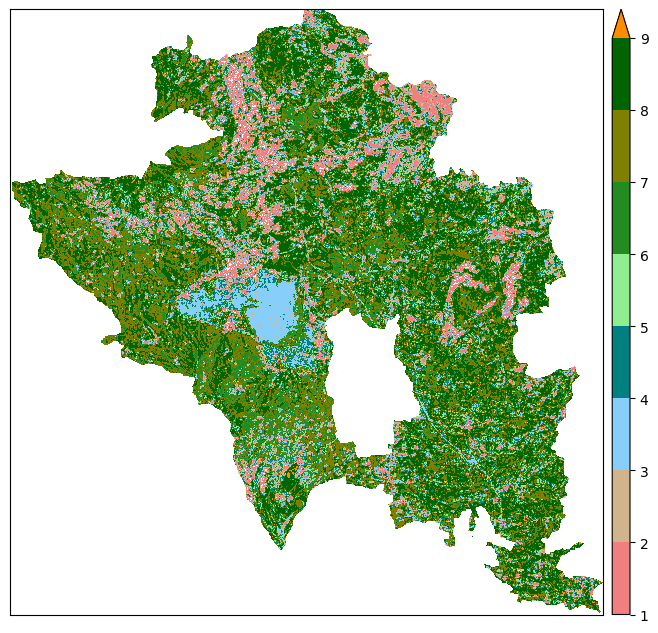

In [7]:
if (MODEL == 'RF'):
    # Load image
    image = rasterio.open(IMAGE_PATH)
    
    bandNum = image.count
    height = image.height
    width = image.width
    crs = image.crs
    transform = image.transform
    shape = (height, width)

    image_data = []

    # Collect valid features
    used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
    for i in used_image_feature:
        band_data = image.read(i).flatten()
        image_data.append(band_data)

    # Create DataFrame for image data
    image_df = pd.DataFrame(np.array(image_data).T, columns=FEATURES)
    
    # Replace invalid values in elevation (e.g., NaN, Inf)
    image_df['elevation'] = image_df['elevation'].replace([np.inf, -np.inf, np.nan], 0).astype(np.int64)

    # Dynamically identify valid pixels (rows without NaN or all-zero features)
    valid_pixels = ~((image_df == 0).all(axis=1) | image_df.isnull().any(axis=1))
    valid_data = image_df[valid_pixels]

    # Convert valid data to TensorFlow dataset
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_data)

    # Predict on valid data
    prediction = model(dict(valid_data))
    valid_predicted_classes = np.argmax(prediction, axis=1)

    # Create an empty array for the output and fill in only valid predictions
    image_predicted_classes = np.full(image_df.shape[0], np.nan)  # Initialize with NaN
    image_predicted_classes[valid_pixels] = valid_predicted_classes

    # Reshape predictions back to the original image dimensions
    image_predicted_classes = image_predicted_classes.reshape(shape)

    # Visualize the predictions
    cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
    ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=(8, 8))
    plt.show()


In [8]:
# Save file to drive
save_location = 'saved_data/'
name = f'Output_{MODEL}.tif'
location = save_location + name

# Save the classified image to a file
with rasterio.open(
    location,
    'w',
    driver='GTiff',
    height=image_predicted_classes.shape[0],
    width=image_predicted_classes.shape[1],
    count=1,
    dtype=image_predicted_classes.dtype.name,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(image_predicted_classes, 1)

print('File saved to ' + location)

File saved to saved_data/Output_RF.tif


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1521, 'height': 1552, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026949458523585647, 0.0, 110.2518517875003,
       0.0, -0.00026949458523585647, -7.078814270390242), 'blockxsize': 1521, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


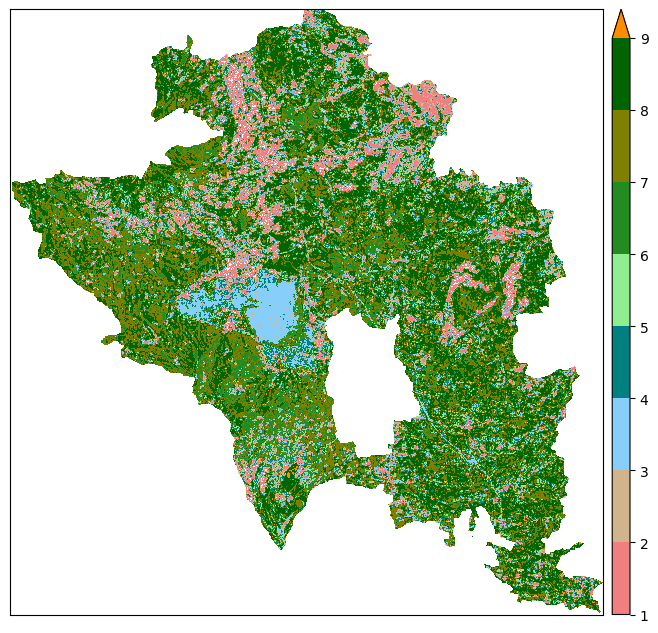

In [9]:
test_open_output = rasterio.open(location)

print(test_open_output.profile)

ep.plot_bands(test_open_output.read(1), cmap=cmap, norm=norm, figsize=PLOT_SIZE)
plt.show()

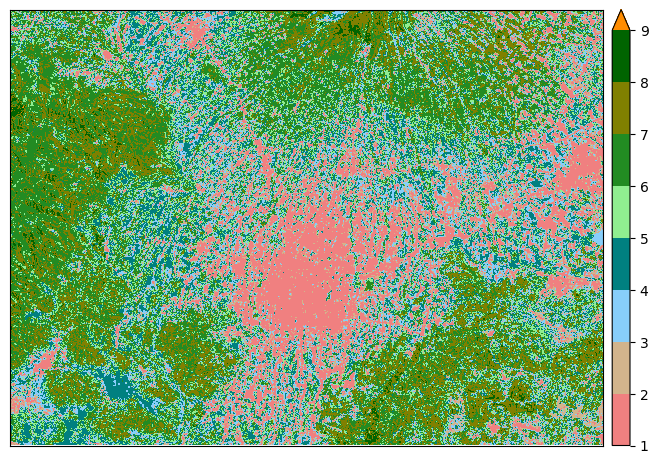

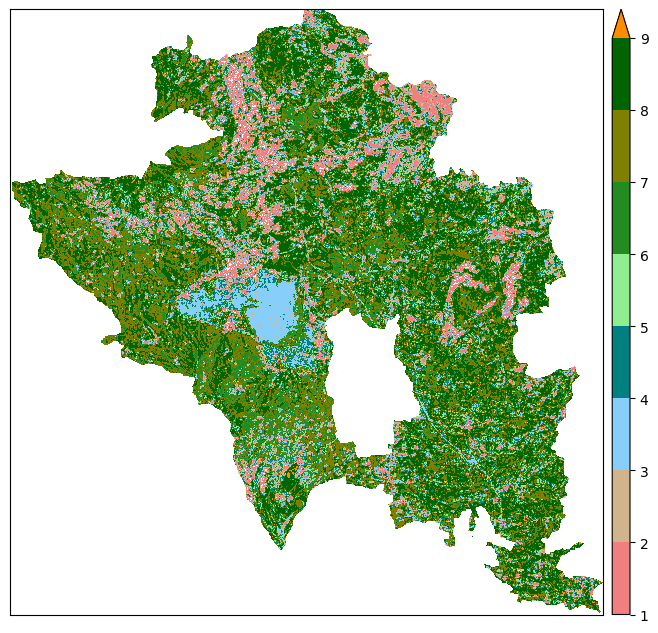

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1521, 'height': 1552, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026949458523585647, 0.0, 110.2518517875003,
       0.0, -0.00026949458523585647, -7.078814270390242)}


In [10]:
# CNN vs RNN

CNN_Output = rasterio.open('saved_data/Output_CNN.tif')
RNN_Output = rasterio.open('saved_data/Output_RF.tif')

ep.plot_bands(CNN_Output.read(1), cmap=cmap, norm=norm, figsize=PLOT_SIZE)
plt.show()
ep.plot_bands(RNN_Output.read(1), cmap=cmap, norm=norm, figsize=PLOT_SIZE)
plt.show()

print(RNN_Output.meta)

In [11]:
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')

# Apply the colormap to the predicted classes (this assumes `prediction` or `image_predicted_classes` is already in class labels 1-9)
colored_prediction = cmap(image_predicted_classes)

# Convert the colored prediction (RGBA) to RGB by discarding the alpha channel
colored_prediction_rgb = (colored_prediction[:, :, :3] * 255).astype(np.uint8)  # Convert to uint8 and scale to 0-255

# Save the output with the correct resolution
save_location = 'saved_data/'
name = 'Output_test.tif'
location = save_location + name

# Write the RGB image to the TIFF file
new_dataset = rasterio.open(
    location,
    mode='w', driver='GTiff',
    height=colored_prediction_rgb.shape[0], width=colored_prediction_rgb.shape[1],
    count=3, dtype='uint8',  # RGB has 3 channels
    crs=crs,
    transform=transform
)

# Write each channel (RGB) to the file
for i in range(3):
    new_dataset.write(colored_prediction_rgb[:, :, i], i + 1)

new_dataset.close()


In [12]:
# Count non-NaN pixels in the DataFrame
non_nan_pixel_count = image_df.notnull().all(axis=1).sum()

# Print the result
print(f"Number of non-NaN pixels: {non_nan_pixel_count}")

Number of non-NaN pixels: 1137706
